In [2]:
from bigraph_viz import plot_bigraph, generate_types

In [3]:
core = generate_types()

core.register('petri', {'_inherit': 'string'})
core.register('cobra', {'_inherit': 'string'})
core.register('sbml', {'_inherit': 'string'})
core.register('sbml_path', {'_inherit': 'string'})
core.register('pyro_module', {'_inherit': 'string'})
core.register('pd.DataFrame', {'_inherit': 'string'})  # TODO -- make these correct

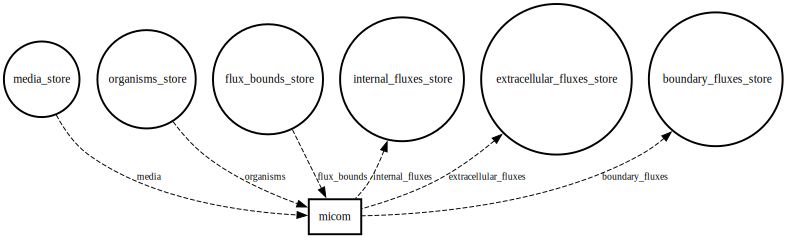

In [4]:
micom = {
    'micom': {
        '_type': 'process',
        '_inputs': {
            'media': 'map[float]',
            'organisms': 'map[cobra]',  # {species_id: cobra_model}
            # 'kinetic_parameters': 'map[float]',  # from {rxn_id: (kcat, km)}  #
            'flux_bounds': ''  # This can set by an kinetics process 
        },
        '_outputs': {
            'internal_fluxes': 'map[float]',       # this will be map[map[float]], with {species: {rxn_id: flux}}
            'extracellular_fluxes': 'map[float]',  # from organism to extracellular
            'boundary_fluxes': 'map[float]',       # from extracellular to the medium
        },
        'inputs': {
            'media': ['media_store'],
            'organisms': ['organisms_store'],
            'flux_bounds': ['flux_bounds_store'], 
        },
        'outputs': {
            'internal_fluxes': ['internal_fluxes_store'],
            'extracellular_fluxes': ['extracellular_fluxes_store'],
            'boundary_fluxes': ['boundary_fluxes_store']
        }
    }
}
plot_bigraph(micom, core=core)

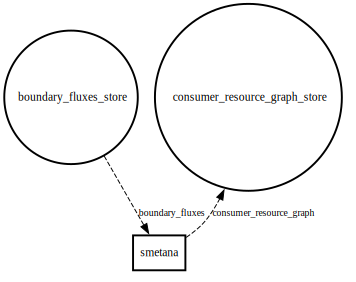

In [5]:
smetana = {
    'smetana': {
        '_type': 'process',
        '_inputs': {
            'boundary_fluxes': 'map[float]',    # from extracellular to the medium
        },
        '_outputs': {
            'consumer_resource_graph': 'any',   # make this type
        },
        'inputs': {
            'boundary_fluxes': ['boundary_fluxes_store']
        },
        'outputs': {
            'consumer_resource_graph': ['consumer_resource_graph_store']
        }
    }
}
plot_bigraph(smetana, core=core)

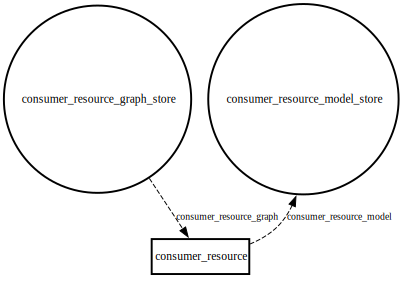

In [6]:
consumer_resource = {
    'consumer_resource': {
        '_type': 'process',
        '_inputs': {
            'consumer_resource_graph': 'petri'  # bipartite graph between organisms and metabolites
        },
        '_outputs': {
            'consumer_resource_model': 'sbml_path',  # this should report the path where the sbml is saved
        },
        'inputs': {
            'consumer_resource_graph': ['consumer_resource_graph_store']
        },
        'outputs': {
            'consumer_resource_model': ['consumer_resource_model_store']
        }
    }
}
plot_bigraph(consumer_resource, core=core)

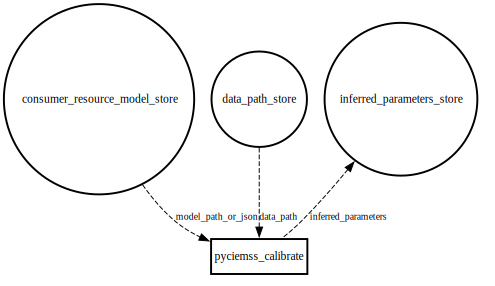

In [7]:
# https://github.com/ciemss/pyciemss/blob/221c4244796343b4f6492dcb8c08aa7ad1e1c4b5/pyciemss/interfaces.py#L585C9-L667C1
pyciemss_calibrate = {
    'pyciemss_calibrate': {
        '_type': 'process',
        '_inputs': {
            'model_path_or_json': 'sbml_path',  # this is actually a path...
            'data_path': 'path', 
        },
        '_outputs': {
            'inferred_parameters': 'pyro_module',  # this is actually a path...
        },
        'inputs': {
            'model_path_or_json': ['consumer_resource_model_store'],
            'data_path': ['data_path_store']
        },
        'outputs': {
            'inferred_parameters': ['inferred_parameters_store']
        }
    }
}
plot_bigraph(pyciemss_calibrate, core=core)

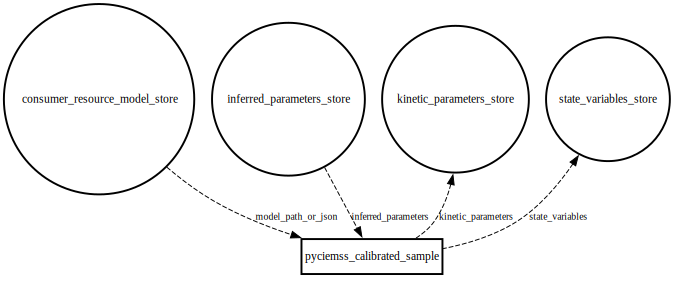

In [8]:
# https://github.com/ciemss/pyciemss/blob/221c4244796343b4f6492dcb8c08aa7ad1e1c4b5/pyciemss/interfaces.py#L371-L447
pyciemss_calibrated_sample = {
    'pyciemss_calibrated_sample': {
        '_type': 'process',
        '_inputs': {
            'model_path_or_json': 'sbml_path',  # this is actually a path...
            'inferred_parameters': 'pyro_module',  # should be maybe[pyro_module], TODO -- make pyro_module compatible with maybe[pyro_module]
        },
        '_outputs': {
            'kinetic_parameters': 'pd.DataFrame',
            'state_variables': 'pd.DataFrame',
        },
        'inputs': {
            'model_path_or_json': ['consumer_resource_model_store'],
            'inferred_parameters': ['inferred_parameters_store']
        },
        'outputs': {
            'kinetic_parameters': ['kinetic_parameters_store'],
            'state_variables': ['state_variables_store'],
        }
    }
}
plot_bigraph(pyciemss_calibrated_sample, core=core)

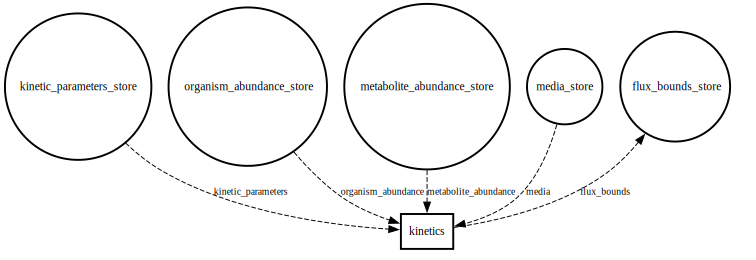

In [12]:
kinetics = {
    'kinetics': {
        '_type': 'process',
        '_inputs': {
            'kinetic_parameters': 'pd.DataFrame',
            'organism_abundance': 'pd.DataFrame',
            'metabolite_abundance': 'pd.DataFrame',  # sbml_species
            'media': 'map[float]'
        },
        '_outputs': {
            'flux_bounds': ''
        },
        'inputs': {
            'kinetic_parameters': ['kinetic_parameters_store'],
            'organism_abundance': ['organism_abundance_store'],
            'metabolite_abundance': ['metabolite_abundance_store'],
            'media': ['media_store']
        },
        'outputs': {
            'flux_bounds': ['flux_bounds_store']
        },
        
    }
}
plot_bigraph(kinetics, core=core)

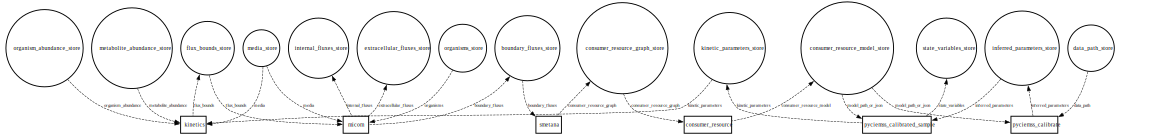

In [13]:
composite = {
    **micom,
    **smetana,
    **consumer_resource,
    **pyciemss_calibrate,
    **pyciemss_calibrated_sample,
    **kinetics,
}
plot_bigraph(composite, core=core)

In [ ]:
# TODO -- make the super-box with ports